1. Import necessary libraries

In [1]:
# Import necessary libraries
print("Import necessary libraries")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import warnings

Import necessary libraries


2. Configure settings

In [2]:
# First of all read parameters from configuration file
assert os.path.exists('../configuration.yaml'), "Configuration file 'configuration.yaml' not found."
with open('../configuration.yaml') as file:
    parameters = yaml.safe_load(file)

# Check the parameters
assert parameters['batchSize'] > 0, "Batch size must be greater than 0."
assert parameters['imgHeight'] == parameters['imgWidth'], "Image height and width must be equal."
assert parameters['trainDatasetPath'] is not None, "Train dataset path must be specified."
assert parameters['epochs'] > 0, "Number of epochs must be greater than 0."

# If everything is ok, print the parameters
print("[INFO] Configuration parameters...")
print("* Batch size........................:", parameters['batchSize'])
print("* Image height......................:", parameters['imgHeight'])
print("* Image width.......................:", parameters['imgWidth'])
print("* Train dataset path................:", parameters['trainDatasetPath'])
print("* Number of epochs..................:", parameters['epochs'])

# Ignore warnings
warnings.filterwarnings(
    "ignore", category=UserWarning
)

[INFO] Configuration parameters...
* Batch size........................: 32
* Image height......................: 180
* Image width.......................: 180
* Train dataset path................: data/train
* Number of epochs..................: 5


3. Create necessary functions

In [3]:
# Function to load the dataset
def loadDataset(path, batchsz, imgHeight, imgWidth):
    print("[INFO] Loading dataset...")

    trainDataset = tf.keras.utils.image_dataset_from_directory(
        path,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(imgHeight, imgWidth),
        batch_size=batchsz
    )

    validDataset = tf.keras.utils.image_dataset_from_directory(
        path,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(imgHeight, imgWidth),
        batch_size=batchsz
    )

    # Get the class names and number of classes
    classNames = trainDataset.class_names
    numClasses = len(classNames)

    print("[INFO] Number of training samples:", len(trainDataset))
    print("[INFO] Class names:", classNames)

    # Cache and prefetch the datasets for performance and shuffling dataset sort
    autotune = tf.data.AUTOTUNE
    trainDataset.cache().shuffle(1000).prefetch(buffer_size=autotune)
    validDataset.cache().prefetch(buffer_size=autotune)

    # Return the datasets, class names, and number of classes
    return trainDataset, validDataset, classNames, numClasses




In [4]:
# Function to build the model
def buildModel(imgWidth, imgHeight, numClasses):
    print("[INFO] Building model...")

    # Define the data augmentation layer and the model architecture
    dataAugmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal',
                                   input_shape=(imgHeight, imgWidth, 3)
                                   ),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1)

    ])

    # Build the model
    model = tf.keras.Sequential([
        dataAugmentation,
        tf.keras.layers.Rescaling(1. / 255),
        tf.keras.layers.Conv2D(16,
                               3,
                               padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32,
                               3,
                               padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64,
                               3,
                               padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,
                              activation='relu'),
        tf.keras.layers.Dense(numClasses,
                              activation='softmax')
    ])

    return model

In [5]:
# Function to compile the model
def compileModel(model):
    print("[INFO] Compiling model...")

    # Compile the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['acc']
    )

    # Print the model summary
    model.summary()

In [6]:
# Function to train the model
def trainModel(model, epochs, trainDataset, validDataset):
    print("[INFO] Training model...")

    # Train the model using the training dataset and validate it using the validation dataset
    history = model.fit(
        trainDataset,
        validation_data=validDataset,
        epochs=epochs,
    )

    return history

4. Visualize training history

In [7]:
# function to visualize training history
def visualizeTrainingHistory(history, epochs):
    print("[INFO] Visualizing training history...")

    # Extract accuracy and loss from the history
    acc = history.history['acc']
    valAcc = history.history['val_acc']
    loss = history.history['loss']
    valLoss = history.history['val_loss']
    epochsRange = range(epochs)

    # Plot accuracy
    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochsRange, acc, label='Akurasi Training')
    plt.plot(epochsRange, valAcc, label='Akurasi Validasi')
    plt.legend(loc='lower right')
    plt.title('Akurasi Training dan Validasi')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochsRange, loss, label='Loss Training')
    plt.plot(epochsRange, valLoss, label='Loss Validasi')
    plt.legend(loc='upper right')
    plt.title('Loss Training dan Validasi')

    # Show the plots
    plt.show()

5. Define the main function for classification

In [8]:
# Function to perform classification
def classification(path, batchSize, imgHeight, imgWidth, epochs):
    # 1. Load the dataset
    trainDataset, validDataset, classNames, numClasses = loadDataset(
        path, batchSize, imgHeight, imgWidth
    )

    # 2. Build the model
    model = buildModel(
        imgWidth, imgHeight, numClasses
    )

    # 3. Compile the model
    compileModel(model)

    # 4. Train the model
    history = trainModel(
        model, epochs, trainDataset, validDataset
    )

    # 5. Save the model
    model.save('classification_model.keras')

    # 6. Visualize the training history
    visualizeTrainingHistory(history, epochs)


[INFO] Loading dataset...
Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.
[INFO] Number of training samples: 108
[INFO] Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
[INFO] Building model...
[INFO] Compiling model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

[INFO] Training model...
Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - acc: 0.4496 - loss: 1.2671 - val_acc: 0.5689 - val_loss: 1.1083
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - acc: 0.5941 - loss: 1.0276 - val_acc: 0.6141 - val_loss: 0.9653
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step - acc: 0.6381 - loss: 0.9373 - val_acc: 0.6292 - val_loss: 0.9836
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - acc: 0.6711 - loss: 0.8648 - val_acc: 0.6756 - val_loss: 0.8481
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - acc: 0.6818 - loss: 0.8206 - val_acc: 0.6837 - val_loss: 0.8478
[INFO] Visualizing training history...


<Figure size 1200x400 with 0 Axes>

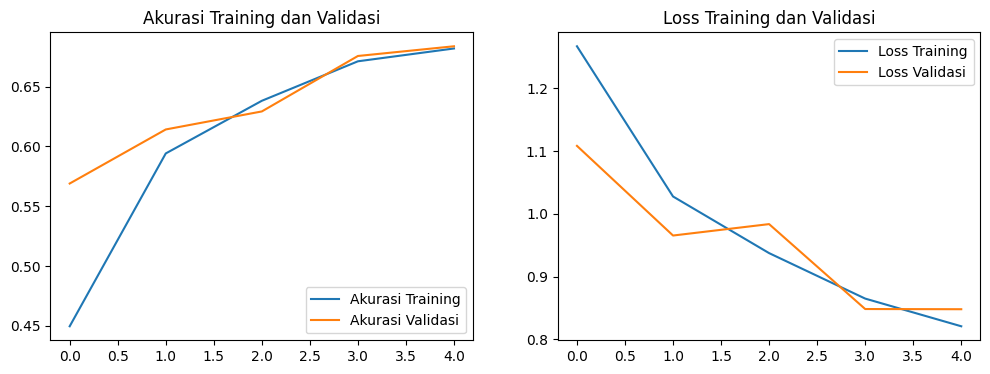

In [9]:
# Check the directory of the training dataset
if not os.path.exists(parameters['trainDatasetPath']):
    print(f"[ERROR] Training dataset path '{parameters['trainDatasetPath']}' does not exist.")
else:
    classification(
        parameters['trainDatasetPath'],
        parameters['batchSize'],
        parameters['imgHeight'],
        parameters['imgWidth'],
        parameters['epochs']
    )